In [1]:
import os, time, copy, random, hashlib
import numpy as np
import torch, torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torch.cuda.amp import autocast, GradScaler
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [2]:
# Configuration
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Using device:", device)

🖥️ Using device: cuda


In [3]:
# Dataset & transforms
dataset_path = "D:\Internship(sujesh)\PlantVillage2"
img_size = 180

train_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
import os
import hashlib
from collections import defaultdict
from typing import Dict, List, Set

# ---------- helpers -----------------------------------------------------------
def chunked_md5(path: str, block_size: int = 1 << 20) -> str:
    """Return MD5 of a file in constant-memory chunks."""
    h = hashlib.md5()
    try:
        with open(path, "rb") as f:
            for chunk in iter(lambda: f.read(block_size), b""):
                h.update(chunk)
        return h.hexdigest()
    except Exception as e:
        print(f"❌ Error reading {path}: {e}")
        return None

def plural(word: str, n: int) -> str:
    """Return plural form of word if count > 1."""
    return word if n == 1 else word + "s"

def _hash_images(folder_path: str, exts: Set[str] = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}) -> Dict[str, List[str]]:
    """Walk the folder tree and bucket image paths by their MD5 hash."""
    hash_map = defaultdict(list)
    for root, _, files in os.walk(folder_path):
        for fname in files:
            ext = os.path.splitext(fname)[1].lower()
            if ext in exts:
                path = os.path.join(root, fname)
                h = chunked_md5(path)
                if h:  # Only add if hash was successfully computed
                    hash_map[h].append(path)
    return hash_map

# ---------- public API --------------------------------------------------------
def count_duplicates(folder_path: str) -> None:
    """Print how many duplicate groups/files exist (no deletions)."""
    if not os.path.isdir(folder_path):
        print(f"❌ Error: Folder does not exist - {folder_path}")
        return

    hash_map = _hash_images(folder_path)
    dup_groups = [paths for paths in hash_map.values() if len(paths) > 1]
    total_dups = sum(len(g) for g in dup_groups)
    redundant = total_dups - len(dup_groups)

    print("\n📊 Duplicate Report:")
    print(f"🔁 {len(dup_groups)} duplicate {plural('group', len(dup_groups))}")
    print(f"📸 {total_dups} duplicate {plural('image', total_dups)} (including originals)")
    print(f"⚠️  {redundant} redundant {plural('image', redundant)} could be removed")

def remove_duplicate_images(folder_path: str, keep_first: bool = True) -> List[str]:
    """
    Delete redundant byte-for-byte duplicates, keep one copy per group.
    
    Args:
        folder_path: Path to folder to scan for duplicates
        keep_first: If True, keeps first file in each group. If False, keeps the last.
    
    Returns:
        List of removed file paths
    """
    if not os.path.isdir(folder_path):
        print(f"❌ Error: Folder does not exist - {folder_path}")
        return []

    hash_map = _hash_images(folder_path)
    dup_groups = [sorted(paths) for paths in hash_map.values() if len(paths) > 1]
    total_dups = sum(len(g) for g in dup_groups)
    redundant = total_dups - len(dup_groups)

    removed = []
    for group in dup_groups:
        # Determine which files to keep and which to delete
        if keep_first:
            to_keep, to_delete = group[0], group[1:]
        else:
            to_keep, to_delete = group[-1], group[:-1]

        for dup in to_delete:
            try:
                os.remove(dup)
                removed.append(dup)
            except Exception as e:
                print(f"⚠️ Could not delete {dup}: {e}")

    print("\n🗑️ Removal Report:")
    print(f"🔁 {len(dup_groups)} duplicate {plural('group', len(dup_groups))}")
    print(f"📸 {total_dups} duplicate {plural('image', total_dups)} (including originals)")
    print(f"✅ Removed {len(removed)} redundant {plural('image', len(removed))}")
    print(f"💾 Kept 1 image from each duplicate group")
    
    return removed

# ---------- example usage -----------------------------------------------------
if __name__ == "__main__":
    folder = r"D:\Internship(sujesh)\PlantVillage2"  # raw string for Windows paths
    
    # First count duplicates
    count_duplicates(folder)
    
    # Uncomment to actually remove duplicates (keeps first file in each group)
    # remove_duplicate_images(folder, keep_first=True)
    remove_duplicate_images(folder)  # This will delete the 2 redundant files
    # Alternative: keeps last file in each group instead
    # remove_duplicate_images(folder, keep_first=False)


📊 Duplicate Report:
🔁 0 duplicate groups
📸 0 duplicate images (including originals)
⚠️  0 redundant images could be removed

🗑️ Removal Report:
🔁 0 duplicate groups
📸 0 duplicate images (including originals)
✅ Removed 0 redundant images
💾 Kept 1 image from each duplicate group


In [5]:
# def remove_duplicate_images(folder_path):
#     hash_map = defaultdict(list)
#     for root, _, files in os.walk(folder_path):
#         for fname in files:
#             if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif")):
#                 path = os.path.join(root, fname)
#                 try:
#                     with open(path, "rb") as f:
#                         h = hashlib.md5(f.read()).hexdigest()
#                     hash_map[h].append(path)
#                 except Exception as e:
#                     print(f"❌ Error reading {path}: {e}")
#     removed = []
#     for group in hash_map.values():
#         for dup in group[1:]:
#             try:
#                 os.remove(dup)
#                 removed.append(dup)
#             except Exception as e:
#                 print(f"⚠️ Could not delete {dup}: {e}")
#     print(f"✅ Removed {len(removed)} duplicate images.")
#     return removed

# remove_duplicate_images(dataset_path)

In [6]:
# Model builder for VGG16
from torchvision import models

full_ds = datasets.ImageFolder(dataset_path, transform=train_tfms)
class_names = full_ds.classes
num_classes = len(class_names)

def build_vgg16(num_classes, dropout=0.3):
    model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)

    for param in model.features.parameters():
        param.requires_grad = True  # fine-tune entire model

    in_f = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(in_f, num_classes)
    )

    return model.to(device)





In [7]:
# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.best_model = None
        self.stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

In [8]:
# 🔁 K-Fold CV + Hyperparameter tuning (light)
from itertools import product

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)
batch_sizes = [16]
learning_rates = [1e-4]
dropouts = [0.3]

for fold, (train_idx, val_idx) in enumerate(kf.split(full_ds)):
    print(f"\n🔁 Fold {fold+1}/{k_folds}")

    train_subset = torch.utils.data.Subset(full_ds, train_idx)
    val_subset = torch.utils.data.Subset(full_ds, val_idx)
    train_subset.dataset.transform = train_tfms
    val_subset.dataset.transform = val_tfms

    for bs, lr, do in product(batch_sizes, learning_rates, dropouts):
        print(f"\n🔧 Testing: Fold={fold+1} | BS={bs}, LR={lr}, DO={do}")

        batch_size = bs
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                                  num_workers=4, pin_memory=True, persistent_workers=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False,
                                num_workers=4, pin_memory=True, persistent_workers=True)

        train_size = len(train_subset)
        val_size = len(val_subset)

        # ✅ Load pretrained VGG16 and modify classifier
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        for param in model.features.parameters():
            param.requires_grad = True  # Fine-tune entire model

        in_f = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Dropout(p=do),
            nn.Linear(in_f, num_classes)
        )

        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
        early_stop = EarlyStopping(patience=5)

        history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'train_acc': []}
        max_epochs = 10
        scaler = GradScaler()

        for epoch in range(1, max_epochs + 1):
            t0 = time.time()

            # 🔹 Training
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            train_loss = running_loss / train_size
            train_acc = correct_train / total_train

            # 🔸 Validation
            model.eval()
            vloss, correct = 0.0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    vloss += loss.item() * images.size(0)
                    preds = outputs.argmax(1)
                    correct += (preds == labels).sum().item()

            val_loss = vloss / val_size
            val_acc = correct / val_size

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch:03}/{max_epochs} | train_loss {train_loss:.4f} | train_acc {train_acc*100:.2f}% | "
                  f"val_loss {val_loss:.4f} | val_acc {val_acc*100:.2f}% | time {time.time()-t0:.1f}s")

            scheduler.step(val_loss)
            for param_group in optimizer.param_groups:
                print(f"🔄 Learning Rate: {param_group['lr']}")

            early_stop(val_loss, model)
            if early_stop.stop:
                print("⏹ Early stopping triggered.")
                break

        model.load_state_dict(early_stop.best_model)
        model_path = f"vgg16_fold{fold+1}_bs{bs}_lr{lr}_do{do}.pth"
        torch.save(model.state_dict(), model_path)
        print("✅ Best model saved to", model_path)





🔁 Fold 1/5

🔧 Testing: Fold=1 | BS=16, LR=0.0001, DO=0.3
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\STUDENT/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100.0%
C:\Users\STUDENT\AppData\Local\Temp\ipykernel_15908\4214346554.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\STUDENT\AppData\Local\Temp\ipykernel_15908\4214346554.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 001/10 | train_loss 0.5452 | train_acc 83.07% | val_loss 0.2212 | val_acc 93.94% | time 137.5s
🔄 Learning Rate: 0.0001
Epoch 002/10 | train_loss 0.1752 | train_acc 94.84% | val_loss 0.0770 | val_acc 97.60% | time 120.7s
🔄 Learning Rate: 0.0001
Epoch 003/10 | train_loss 0.1146 | train_acc 96.79% | val_loss 0.1036 | val_acc 96.70% | time 121.6s
🔄 Learning Rate: 0.0001
Epoch 004/10 | train_loss 0.0821 | train_acc 97.51% | val_loss 0.1525 | val_acc 95.98% | time 121.0s
🔄 Learning Rate: 0.0001
Epoch 005/10 | train_loss 0.0934 | train_acc 97.36% | val_loss 0.1098 | val_acc 97.19% | time 120.9s
🔄 Learning Rate: 1e-05
Epoch 006/10 | train_loss 0.0093 | train_acc 99.72% | val_loss 0.0488 | val_acc 98.69% | time 120.9s
🔄 Learning Rate: 1e-05
Epoch 007/10 | train_loss 0.0037 | train_acc 99.91% | val_loss 0.0539 | val_acc 98.64% | time 121.1s
🔄 Learning Rate: 1e-05
Epoch 008/10 | train_loss 0.0019 | train_acc 99.96% | val_loss 0.0458 | val_acc 98.93% | time 120.8s
🔄 Learning Rate: 1e-05
Epoc

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def build_vgg16(num_classes=15, dropout=0.3, checkpoint_path="VGG16_final_20250715-1127.pth"):
    # 1. Initialize model with ImageNet weights
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    
    # 2. Modify classifier to EXACTLY match how it was during training
    # (using Sequential with both Dropout and Linear)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(in_features, num_classes)
    )
    
    # 3. Load checkpoint with proper key handling
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        # Directly load without key modification since we matched the architecture
        model.load_state_dict(checkpoint)
        print(f"Successfully loaded weights from {checkpoint_path}")
    
    except RuntimeError as e:
        print("Original load failed, attempting key conversion...")
        try:
            # Create new state dict with converted keys
            new_state_dict = {}
            for k, v in checkpoint.items():
                if 'classifier.6.0' in k:  # Dropout layer
                    continue  # Skip dropout parameters
                elif 'classifier.6.1' in k:  # Linear layer
                    new_k = k.replace('6.1', '6')
                    new_state_dict[new_k] = v
                else:
                    new_state_dict[k] = v
            
            # Load basic VGG16 and modify just the final layer
            basic_model = models.vgg16(weights=None)
            basic_model.classifier[6] = nn.Linear(4096, num_classes)
            basic_model.load_state_dict(new_state_dict, strict=False)
            model = basic_model
            print("Loaded with key conversion (some dropout parameters skipped)")
        except Exception as e:
            print(f"Failed to load checkpoint: {e}")
            raise
    
    model = model.to(device)
    model.eval()
    return model

# Usage:
model = build_vgg16(num_classes=15)

Successfully loaded weights from VGG16_final_20250715-1127.pth


In [9]:
print(model)
test_input = torch.randn(1, 3, 224, 224).to(device)
output = model(test_input)
print(f"Output shape: {output.shape}")  # Should be [1, num_classes]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
import torch
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms

# ----------------------------
# 0 — basic hyper‑params
# ----------------------------
root_dir   = "D:\Internship(sujesh)\PlantVillage2"   # ↩️  folder arranged as class‑name sub‑dirs
img_size   = 224
batch_size = 32
seed       = 42                    # for reproducible split

# ----------------------------
# 1 — define transforms
# ----------------------------
train_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ----------------------------
# 2 — load the full dataset (no transform yet)
# ----------------------------
full_ds = datasets.ImageFolder(root=root_dir)

# ----------------------------
# 3 — 80‑20 split
# ----------------------------
test_size  = int(0.2 * len(full_ds))
train_size = len(full_ds) - test_size

train_subset, test_subset = random_split(
    full_ds,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(seed)
)

# ----------------------------
# 4 — wrap each subset so it gets its own transform
# ----------------------------
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform):
        self.subset    = subset              # torch.utils.data.Subset
        self.transform = transform
        self.classes   = subset.dataset.classes  # keep class names

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]        # img is a PIL Image
        return self.transform(img), label

train_ds = SubsetWithTransform(train_subset, train_tfms)
test_ds  = SubsetWithTransform(test_subset,  test_tfms)   # ← 20 % of data

# ----------------------------
# 5 — build loaders
# ----------------------------
train_loader = DataLoader(train_ds,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True)

test_loader  = DataLoader(test_ds,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True)

print(f"📊 Train samples: {len(train_ds)}")
print(f"🧪 Test  samples: {len(test_ds)}  (exactly 20 % of full dataset)")


📊 Train samples: 22002
🧪 Test  samples: 5500  (exactly 20 % of full dataset)


In [ ]:
# ✅ Run on test set
model.eval()
correct_test, total_test = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

test_acc = correct_test / total_test
print(f"🧪 Final Test Accuracy: {test_acc * 100:.2f}%")

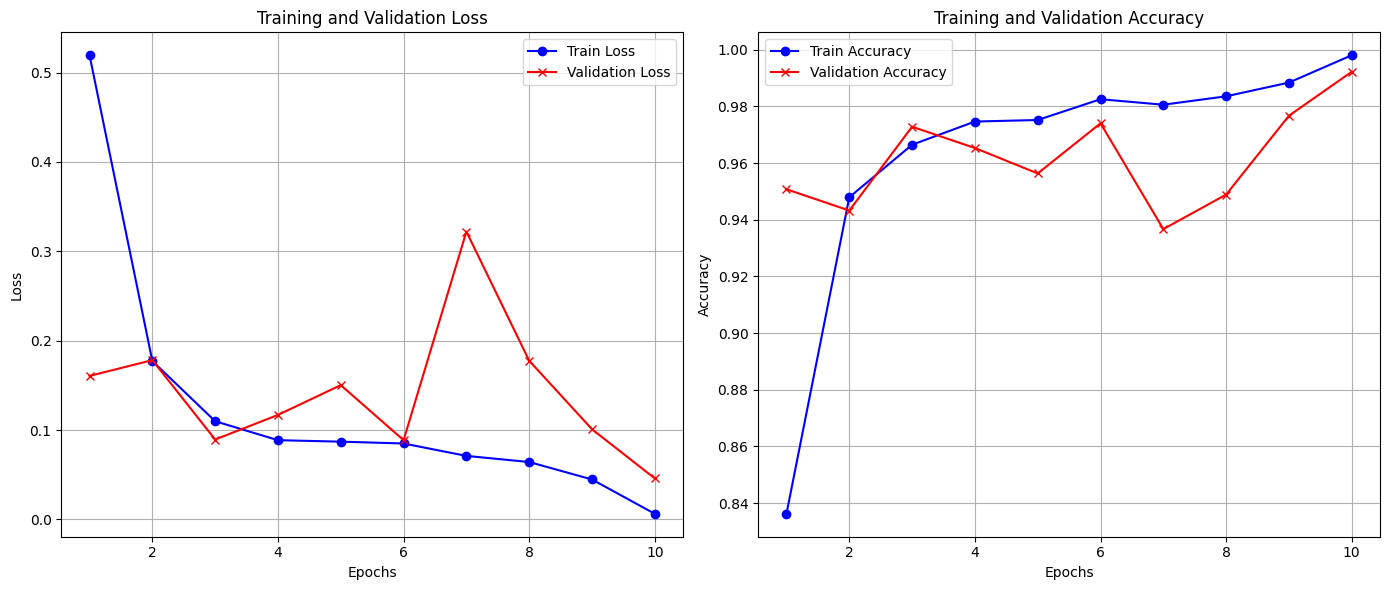


Training History Table:
   epoch  train_loss  val_loss  val_acc  train_acc
0      1      0.5194    0.1606   0.9508     0.8362
1      2      0.1773    0.1783   0.9433     0.9479
2      3      0.1099    0.0894   0.9728     0.9665
3      4      0.0887    0.1169   0.9653     0.9747
4      5      0.0870    0.1503   0.9564     0.9752
5      6      0.0850    0.0887   0.9741     0.9825
6      7      0.0711    0.3221   0.9367     0.9806
7      8      0.0642    0.1776   0.9489     0.9836
8      9      0.0447    0.1009   0.9767     0.9884
9     10      0.0063    0.0458   0.9922     0.9981


<Figure size 640x480 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Your training history data
history = {
    'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'train_loss': [0.5194489345550537, 0.17728743358091875, 0.10988423831535109, 
                  0.08866695578170546, 0.08703336129044041, 0.08496884734702833,
                  0.07109278153650889, 0.06423611558567394, 0.04470915286468737, 
                  0.006292860096151178],
    'val_loss': [0.1605920008809092, 0.1782760906903027, 0.089426855039967199,
                0.1169301815058879, 0.15030198341460108, 0.08865310044264953,
                0.3221349217115821, 0.1775911400178583, 0.10092792240915371,
                0.04583083688999379],
    'val_acc': [0.9507759456838021, 0.9432589718719689, 0.9728419010669254,
               0.9653249272550921, 0.95635305528613, 0.9740543161978662,
               0.9367119301648884, 0.9488962172647915, 0.976721629485936,
               0.9922405431619786],
    'train_acc': [0.83624242424242, 0.94793939393934, 0.96648484848485,
                 0.974666666666667, 0.97521212121212, 0.98254545454545,
                 0.98060606060606, 0.98357575757575, 0.98842424242424,
                 0.99806060606061]
}

# Create figure
plt.figure(figsize=(14, 6))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history['epoch'], history['train_loss'], 'b-o', label='Train Loss')
plt.plot(history['epoch'], history['val_loss'], 'r-x', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history['epoch'], history['train_acc'], 'b-o', label='Train Accuracy')
plt.plot(history['epoch'], history['val_acc'], 'r-x', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')

# Bonus: Create a pandas DataFrame for better viewing
df = pd.DataFrame(history)
print("\nTraining History Table:")
print(df.round(4))  # Display values with 4 decimal places

In [46]:
import pickle

# Replace filename to match your fold and settings
history_path = "history_Vgg16_fold1_bs16_lr0.0001_do0.3.pkl"

with open(history_path, "wb") as f:
    pickle.dump(history, f)

print("✅ History saved as", history_path)


# (in function) 
# def load_history(model_name, fold, bs, lr, do):
#     filename = f"history_{model_name}_fold{fold}_bs{bs}_lr{lr}_do{do}.pkl"
#     with open(filename, "rb") as f:
#         return pickle.load(f)

# # Example
# history = load_history("mobilenet", fold=1, bs=16, lr=1e-4, do=0.3)

with open("history_Vgg16_fold1_bs16_lr0.0001_do0.3.pkl", "rb") as f:
    history = pickle.load(f)

✅ History saved as history_Vgg16_fold1_bs16_lr0.0001_do0.3.pkl


In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 🟢 Collect predictions
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 📊 Classification Report
print("📊 Classification Report")
print(classification_report(y_true, y_pred, target_names=class_names))

# 📌 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

NameError: name 'val_loader' is not defined

In [14]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
torch.save(model.state_dict(), f"VGG16_final_{timestamp}.pth")

In [15]:
# Manually log the best results from each fold
best_val_acc = max(history['val_acc'])
best_val_loss = min(history['val_loss'])

results = []  # Definition of ResultArray

results.append({
    "batch_size": bs,
    "lr": lr,
    "dropout": do,
    "val_acc": best_val_acc,
    "val_loss": best_val_loss
})

results.append({
    "batch_size": bs,
    "lr": lr,
    "dropout": do,
    "val_acc": best_val_acc,  # capture from training loop
    "val_loss": best_val_loss
})

In [16]:
import pandas as pd
pd.DataFrame(results).to_csv("hyperparameter_results(VGG16).csv", index=False)

In [17]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# ✅ Log to TensorBoard (after loss and acc are computed)
writer.add_scalar("Loss/train", train_loss, epoch)
writer.add_scalar("Loss/val", val_loss, epoch)
writer.add_scalar("Accuracy/val", val_acc, epoch)

writer.close()

In [47]:
import torch
from torchvision import models
import torch.nn as nn

# ⚠️ Set the same dropout you used during training
def build_vgg16(num_classes=15, dropout=0.3):
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    for param in model.features.parameters():
        param.requires_grad = True  # fine-tune full model

    in_f = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(in_f, num_classes)
    )
    return model.to(device)


In [48]:
model = build_vgg16(num_classes=15, dropout=0.3)
model.load_state_dict(torch.load("Vgg16_fold1_bs16_lr0.0001_do0.3.pth", map_location=device))
model.eval()



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [49]:
history_path = "history_Vgg16_fold1_bs16_lr0.0001_do0.3.pkl"
with open(history_path, "rb") as f:
    history = pickle.load(f)


In [50]:
# class_names = [
#     'Pepper__bell___Bacterial_spot',
#     'Pepper__bell___healthy',
#     'Potato___Early_blight',
#     'Potato___Late_blight',
#     'Potato___healthy',
#     'Tomato_Bacterial_spot',
#     'Tomato_Early_blight',
#     'Tomato_Late_blight',
#     'Tomato_Leaf_Mold',
#     'Tomato_Septoria_leaf_spot',
#     'Tomato_Spider_mites_Two_spotted_spider_mite',
#     'Tomato__Target_Spot',
#     'Tomato__Tomato_YellowLeaf__Curl_Virus',
#     'Tomato__Tomato_mosaic_virus',
#     'Tomato_healthy'
# ]

In [51]:
from torch.utils.data import random_split

# Define split sizes (e.g., 10% test)
test_ratio = 0.1
test_size = int(test_ratio * len(full_ds))
remaining_size = len(full_ds) - test_size

# Split into remaining (train+val) and test
remaining_ds, test_ds = random_split(full_ds, [remaining_size, test_size], generator=torch.Generator().manual_seed(seed))

# Apply only validation transforms to test set
test_ds.dataset.transform = val_tfms

# Create DataLoader
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=4)

print(f"🧪 Test dataset created with {len(test_ds)} samples")
# ✅ Run on test set
model.eval()
correct_test, total_test = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

test_acc = correct_test / total_test
print(f"🧪 Final Test Accuracy: {test_acc * 100:.2f}%")

🧪 Test dataset created with 2750 samples
🧪 Final Test Accuracy: 0.80%


In [52]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import cv2
import os

# === CONFIG ===
MODEL_PATH = "vgg16_fold5_bs16_lr0.0001_do0.3.pth"
DATASET_DIR = "D:\Internship(sujesh)\PlantVillage2"
NUM_CLASSES = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
TEST_RATIO = 0.1
VAL_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# === LOAD DATASET AND SPLIT ===
full_ds = ImageFolder(DATASET_DIR, transform=VAL_TRANSFORM)
test_size = int(TEST_RATIO * len(full_ds))
remaining_size = len(full_ds) - test_size
remaining_ds, test_ds = random_split(full_ds, [remaining_size, test_size],
                                     generator=torch.Generator().manual_seed(SEED))
test_indices = test_ds.indices
test_image_paths = [full_ds.samples[i][0] for i in test_indices]

# === LOAD MODEL ===
model = models.densenet121(pretrained=False)
model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE), strict=False)

model.to(DEVICE).eval()

# === Grad-CAM CLASS ===
class GradCAM:
    def __init__(self, model, target_layer="features"):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(forward_hook)
                module.register_backward_hook(backward_hook)

    def __call__(self, x, class_idx=None):
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        output[:, class_idx].backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

def overlay_cam_on_image(heatmap, image_path, alpha=0.4):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    return overlay

# === APPLY Grad-CAM ===
OUTPUT_DIR = "gradcam_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

cam_generator = GradCAM(model, "features")

for i, img_path in enumerate(test_image_paths):
    img = Image.open(img_path).convert("RGB")
    input_tensor = VAL_TRANSFORM(img).unsqueeze(0).to(DEVICE)
    heatmap = cam_generator(input_tensor)
    overlay = overlay_cam_on_image(heatmap, img_path)
    out_path = os.path.join(OUTPUT_DIR, f"gradcam_{i}.jpg")
    cv2.imwrite(out_path, overlay)

print(f"✅ Grad-CAM visualizations saved in: {OUTPUT_DIR}/")

C:\Users\STUDENT\anaconda3\envs\py\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\STUDENT\anaconda3\envs\py\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\STUDENT\anaconda3\envs\py\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


✅ Grad-CAM visualizations saved in: gradcam_outputs/


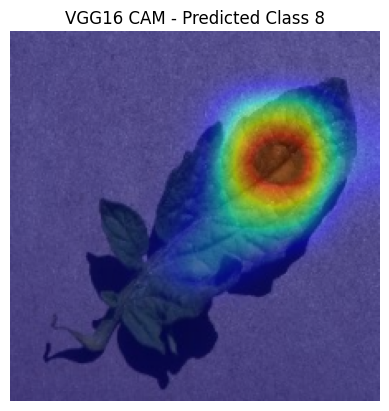

In [53]:
import torch
import torch.nn as nn
from torchvision.models import vgg16
from torchcam.methods import ScoreCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# === Config ===
MODEL_PATH = "vgg16_fold5_bs16_lr0.0001_do0.3.pth"
NUM_CLASSES = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load base VGG16
model = vgg16(pretrained=False)

# ✅ Get input features from original classifier
in_features = model.classifier[6].in_features

# ✅ Match trained classifier structure (Dropout + Linear)
model.classifier[6] = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, NUM_CLASSES)
)

# ✅ Load weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE).eval()

# ✅ Hook CAM extractor
cam_extractor = ScoreCAM(model)

# === Select random image from test set ===
rand_idx = random.randint(0, len(test_ds) - 1)
img_tensor, label = test_ds[rand_idx]

unnormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)
image_vis = to_pil_image(unnormalize(img_tensor))
input_tensor = img_tensor.unsqueeze(0).to(DEVICE)

# === Run inference and ScoreCAM ===
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()
cam_map = cam_extractor(pred_class, output)[0]

# === Overlay and display ===
overlay = overlay_mask(image_vis, to_pil_image(cam_map.cpu(), mode='F'), alpha=0.5)
plt.imshow(overlay)
plt.title(f"VGG16 CAM - Predicted Class {pred_class}")
plt.axis("off")
plt.show()
